In [1]:
from fastai.vision.all import *
import pylab as plt

random.seed(42)

Let's begin by defining a function that will plot the output for any given quadratic function.

In [2]:
def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min,max,steps=20)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x, f(x))
    if tx is not None: ax.set_xlabel(tx)
    if ty is not None: ax.set_ylabel(ty)
    if title is not None: ax.set_title(title)

Here are the steps that are the key to the training of all deep learning models (this paragraph, graph, and following paragraph are adapted from fasiai book chapter 04_mnist_basics,ipynb):

- Initialize the weights.
- For each input (x), use these weights to predict the output ($\hat y$)
- Based on these predictions, calculate how good the model is (its loss). For supervised learning, this involved compare the predicted output to the acutal output (y)
- Calculate the gradient, which measures for each weight, how changing that weight would change the loss
- Step (that is, change) all the weights based on that calculation.
- Repeat the process.

A graph of this process is shown below.

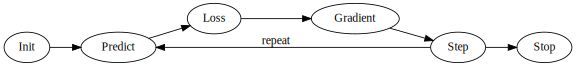

In [3]:
import graphviz as gv

dot = gv.Digraph(comment='The NN Training Cycle')
dot.attr(rankdir='LR', size='8,5')

dot.node("I", "Init")
dot.node("P", "Predict")
dot.node("L", "Loss")
dot.node("G", "Gradient")
dot.node("S", "Step")
dot.node("STOP", "Stop")

dot.edge('I', 'P')

dot.edge('P', 'L')

dot.edge('L', 'G')

dot.edge('G', 'S')

dot.edge('S', 'P', label='repeat')

dot.edge('S', 'STOP')

#['L', 'G'], ['G', 'S'], ['S', 'P'], ['S', 'STOP'])

dot

There are many different ways to do each of these seven steps. These are the details that make a big difference for deep learning practitioners, but it turns out that the general approach to each one generally follows some basic principles. 

Here are a few guidelines:
- **Initialize**:: We initialize the parameters to random values. This may sound surprising. There are certainly other choices we could make, such as initializing them to the percentage of times that pixel is activated for that category—but since we already know that we have a routine to improve these weights, it turns out that just starting with random weights works perfectly well.

- **Loss**:: This is what Samuel referred to when he spoke of testing the effectiveness of any current weight assignment in terms of actual performance. We need some function that will return a number that is small if the performance of the model is good (the standard approach is to treat a small loss as good, and a large loss as bad, although this is just a convention).

- **Step**:: A simple way to figure out whether a weight should be increased a bit, or decreased a bit, would be just to try it: increase the weight by a small amount, and see if the loss goes up or down. Once you find the correct direction, you could then change that amount by a bit more, and a bit less, until you find an amount that works well. However, this is slow! As we will see, the magic of calculus allows us to directly figure out in which direction, and by roughly how much, to change each weight, without having to try all these small changes. The way to do this is by calculating gradients. This is just a performance optimization, we would get exactly the same results by using the slower manual process as well.

- **Stop**:: Once we've decided how many epochs to train the model for (a few suggestions for this were given in the earlier list), we apply that decision. This is where that decision is applied. For an image classifier, we would keep training until the accuracy of the model started getting worse, or we ran out of time.

One can think of NN as a **function** that maps a set of inputs to a set of outputs. Train the NN to map the inputs to the outputs means modifying the weights in such a way that the `loss` is minimized. Fitting the model to the data and minimizing the loss is the essence of machine learning.

So what is this function? That depends on the problem we are trying to solve, but to understand a few key concepts, we will look at a quadratic function as the 'model'.

Let's start by defining the quadratic function $3x^2 + 2x + 1$. 

In [4]:
def quad(x): return 3 * x**2 + 2 * x + 1

Let's generate a plot of our quadratic function.

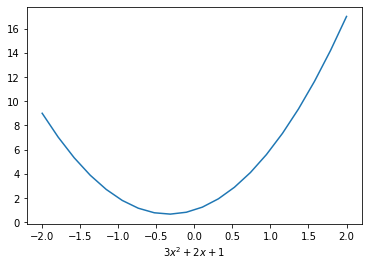

In [5]:
plot_function(quad, '$3x^2 + 2x + 1$')

To make it easy to look at different functions let's define a generalized quadratic function.

In [6]:
def quad(a, b, c, x): return a * x**2 + b * x + c

Let's also define a factory for creating quadratic functions. Factory functions are a broadly used concept in software engineering that hide complexity and provide many other potential benefits. 

We use the `partial` function to 'fix' the values of a, b, and coefficients. Note - a `lambda` would work just as well but `partial` is more flexible and powerful.

In [7]:
from functools import partial
def make_quad(a, b, c) : return partial(quad, a, b, c)

Now we use the factory to re-create our quadratic

In [8]:
f = make_quad(3, 2, 1)

Short sidebar on `partial` functions:

Partial functions are used to derive a specialized function with fewer parameters from the original function by setting constant values to a certain number of arguments. Python Partial functions make code more reusable without altering the original function.

In [9]:
f

functools.partial(<function quad at 0x7f1a1996c320>, 3, 2, 1)

Unlike `lambda`, `partial` functions can be examined for inner details.

In [10]:
f.args

(3, 2, 1)

In [11]:
f.func

<function __main__.quad(a, b, c, x)>

Let's generate some random normally distributed data. We will use out quadratic functiomn to 'fit' this data.

In [12]:
from numpy.random import normal, seed, uniform
def noise(x, scale) : return normal(scale = scale, size = x.shape)
def add_noise(x, mult, add): return x + (1 + noise(x, mult)) + noise(x, add)

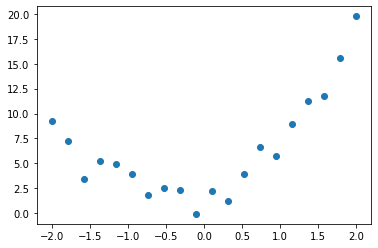

In [13]:
x = torch.linspace(-2, 2, steps=20)[:,None]
y = add_noise(f(x), 0.3, 1.5)
plt.scatter(x, y)

To see how well our quadratic function fits the data, and to try out different variations of the quad coefficients, let's create an interactive function to plot the data together with the output of the quad function. 

We can then vary the quad coefficients to try better to get a better fit.

In [14]:
from ipywidgets import interact

In [15]:
@interact(a = 1.5, b = 1.5, c = 1.5)
def plot_quad(a, b, c):
    plot_function(make_quad(a, b, c))
    plt.scatter(x, y)

interactive(children=(FloatSlider(value=1.5, description='a', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

Playing with the interactive widget was fun but judging whether a particular combination of coefficients is better than previous combinations was very subjective. 

Let's correct that by creating a `loss` function. The function will take the predictions ($\hat y$) and actual observations ($y$) and calculate the Mean Square Error (MSE)

In [16]:
def mse(pred, actual) : return ((pred - actual) ** 2).mean()

Next, we update our interactive function to add MSE to the plot so we can easily tell whether the new coefficient setting is improved and degraded the model.

In [17]:
@interact(a = 1.5, b = 1.5, c = 1.5)
def plot_quad(a, b, c):
    f = make_quad(a, b, c)
    loss = mse(f(x), y)
    title = "MSE: " + str(loss)
    plot_function(f, title=f'MSE: {loss:.2f}')
    plt.scatter(x, y)

interactive(children=(FloatSlider(value=1.5, description='a', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

Cool! That was better but it would be great if finding the best combination of coefficients - i.e. smallest MSE - could be automated. After all, that is our key objective.

Let's wrap the creating of the loss function and calculation of the MSE into a single function `quad_mse`

In [18]:
def quad_mse(params):
    f = make_quad(*params)
    return mse(f(x), y)

For sanity check, let's compute MSE using the `quad_mse` our default coefficient settings `[1.5, 1.5, 1.5]`.

In [19]:
quad_mse([1.5, 1.5, 1.5])

tensor(13.3361, dtype=torch.float64)

This is fun! Let's compute MSE at another set of coefficients. 

Much better!

In [20]:
quad_mse([3.0, 1.5, 1.5])

tensor(2.4671, dtype=torch.float64)

And once more. 

Oops, the loss increased! We will have to undo last change.

In [21]:
quad_mse([3.5, 1.5, 1.5])

tensor(2.7402, dtype=torch.float64)

We can keep doing this and eventually (hopefully) we will arrive at an acceptable loss. That would give us the optimal coefficients for the quad function to fit the data. This is roughly how a NN does its learning!

Short pause - think of the quadratic function as the NN, the quad coefficients as the weights, MSE as the loss function, and modification of coefficients as backward propagation updating the weights.

You may have noticed that sometimes a coefficient value had to be increased (decreased) to get a lower (higher) loss. And we didn't know ahead of time whether it was a good idea to increase (decrease) a particular coefficient. We simply made the change, observed the resulting loss, and only then did we know whether or not the model had improved.

Wouldn't it be nice if we knew whether to increase or decrease a particular coefficient **before** making that change? That's where the gradients comes in!

We will leverage tensors to do the heavy lifting. Let's create a `tensor` to calculate the quadratic MSE.

In [22]:
a_tensor = tensor([1.5, 1.5, 1.5])
a_tensor

tensor([1.5000, 1.5000, 1.5000])

next, we tell Pytorch that we'd like to compute gradient at that tensor. 

Note, Pytorch has flagged (requires_grad) that this tensor requires gradient whenever it's used in calculations

In [23]:
a_tensor.requires_grad_()
a_tensor

tensor([1.5000, 1.5000, 1.5000], requires_grad=True)

Let's compute MSE using the tensor. 

Note, in the output of the calculation Pytorch informs us that it knows how to calculate the gradients

In [24]:
loss = quad_mse(a_tensor)
loss

tensor(13.3361, dtype=torch.float64, grad_fn=<MeanBackward0>)

Let's tell Pytorch to calculate the gradients. 

Nothing seems to have happened, however... 

In [25]:
loss.backward()

Pytorch has updated the tensor with gradients of each coefficient!

We can see that:

- loss will go down by a lot if we increase the $1^{st}$ parameter **a**
- loss will go down somewhat if we increase the $2^{nd}$ parameter **b**
- loss will go down if we increase the $3^{rd}$ parameter **c**

We have now sees a lot of the machinery needed to use the quadratic function (model) to predict ($\hat y$) from the input (x), calculate the `loss`, calculate gradients of model parameters, and modify model parameters.

In [26]:
a_tensor.grad

tensor([-13.0901,  -2.3721,  -5.3556])